# building and training transformer with just pytorch

Transformer predicts next most possible word (token)

bigram: distribution of characters


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
import random
import matplotlib.pyplot as plt
import time
from PyPDF2 import PdfReader
import re
import os
import math
from typing import List


what we need to build a sequence generator
stoi
itos
distribution of each char
limited predictability, limited use

Attention mechanism

语言的本质是什么？
想象一个婴儿是如何知道我们说一个词比如飞机的时候，在说什么？
下意识的答案是我们指给他看飞机这一物件。但婴儿看到飞机时又是如何理解这一物件的呢？当我们将飞机的发音和飞机物件挂上钩时，婴儿并不能真正理解飞机。语言是依托于整个人类的系统，或者说是文明。

深层次是概念的区别。我们理解飞机通过汽车，通过飞行和行驶的二元对立，通过天空和地面的二元对立。换句话说，


In [48]:
from PyPDF2 import PdfReader
import re
reader = PdfReader('ISDA.pdf')
text=''
for i in range(len(reader.pages)):
    page = reader.pages[i]
    text += page.extract_text()
clean_text = re.sub(r'[^\w]', ' ', text).lower()
clean_text = re.sub(r'_', ' ', clean_text)
raw_text = clean_text.split()
number_unique_char =len(set(clean_text))


In [16]:
raw_text

['multicurrency',
 'cross',
 'border',
 'se',
 '2152409',
 'v2',
 'isda',
 'international',
 'swap',
 'dealers',
 'association',
 'inc',
 'master',
 'agreement',
 'dated',
 'as',
 'of',
 'april',
 '6',
 '2006',
 'bear',
 'stearns',
 'financial',
 'products',
 'inc',
 'party',
 'a',
 'and',
 'long',
 'beach',
 'mortgage',
 'loan',
 'supplemental',
 'interest',
 'trust',
 'series',
 '2006',
 '3',
 'party',
 'b',
 'have',
 'entered',
 'and',
 'or',
 'ant',
 'icipate',
 'entering',
 'into',
 'one',
 'or',
 'more',
 'transactions',
 'each',
 'a',
 'transaction',
 'that',
 'are',
 'or',
 'will',
 'be',
 'governed',
 'by',
 'this',
 'master',
 'agreement',
 'which',
 'includes',
 'the',
 'schedule',
 'the',
 'schedule',
 'and',
 'the',
 'documents',
 'and',
 'other',
 'confirming',
 'evidence',
 'each',
 'a',
 'confirmation',
 'exchanged',
 'bet',
 'ween',
 'the',
 'parties',
 'confirming',
 'those',
 'transactions',
 'accordingly',
 'the',
 'parties',
 'agree',
 'as',
 'follows',
 '1',
 'int

In [17]:
N = torch.zeros((number_unique_char, number_unique_char), dtype=torch.int32)
chars = sorted(list(set(''.join(raw_text))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

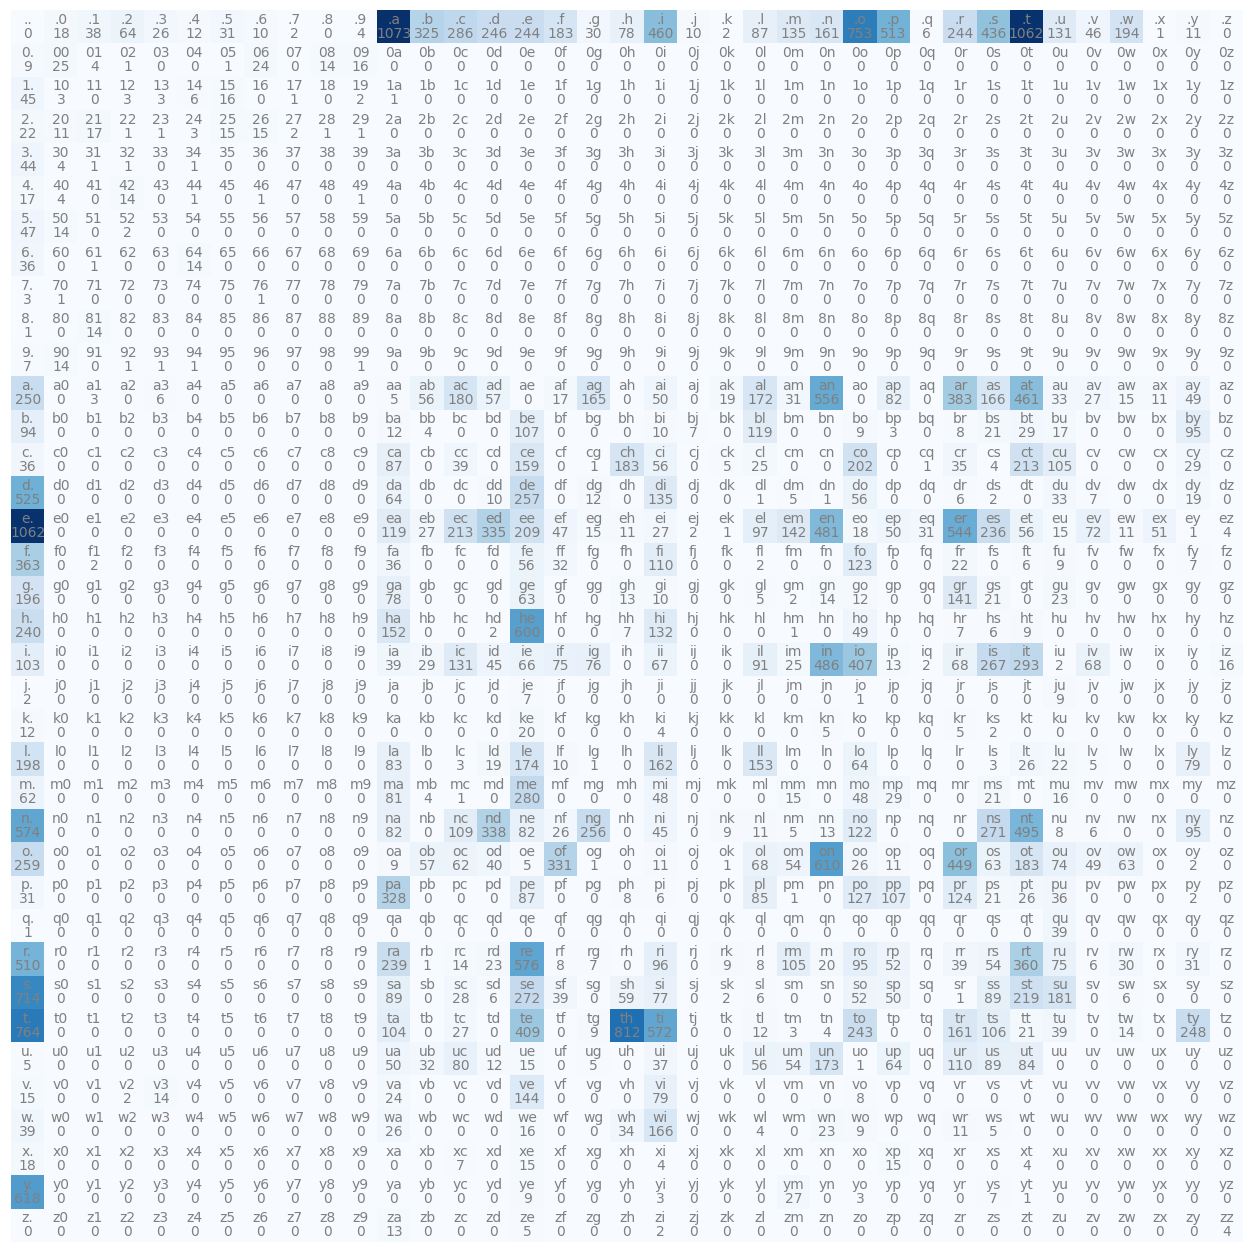

In [18]:
for w in raw_text:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] +=1

import matplotlib.pyplot as plt
# %matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(number_unique_char):
    for j in range(number_unique_char):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.show()

In [6]:
# bigrams method
P = (N+1).float()
P = P / P.sum(1, keepdims=True)
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))
log_likelihood = 0.0
n = 0
for w in raw_text:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll/n=}')

vere.
ie.
litrens.
on.
osf.
log_likelihood=tensor(-89540.5000)
nll/n=tensor(2.2619)


In [7]:
xs, ys = [], []
for w in raw_text[:1]: 
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=number_unique_char).float()
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((number_unique_char, number_unique_char), generator=g)
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(1, keepdims=True)

# real optimization
xs, ys = [], []
for w in raw_text:
    chs = ['.'] +list(w)+ ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
# initializing the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((number_unique_char, number_unique_char), generator=g, requires_grad=True)
# gradient descent
for k in range(1000):
    # forward pass
    xenc = F.one_hot(xs, num_classes=number_unique_char).float()
    logits = xenc @ W
    # softmax
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    # CrossEntropy + regularization
    loss = -probs[torch.arange(num), ys].log().mean()+0.01*(W**2).mean()
    print(loss.item())
    # backward pass
    W.grad = None
    loss.backward()
    # Update W
    W.data += -50*W.grad
# predict/ sample
g = torch.Generator().manual_seed(2147483647)
for i in range(5):

    out = []
    ix = 0
    while True:

        # ----------
        # BEFORE:
        # p = P[ix]
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=number_unique_char).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        # ----------

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

4.051620960235596
3.616624116897583
3.3242902755737305
3.1200430393218994
2.977327823638916
2.8739538192749023
2.7969751358032227
2.7378122806549072
2.6907904148101807
2.6522841453552246
2.6201047897338867
2.5928680896759033
2.569582462310791
2.549480438232422
2.53195858001709
2.516547679901123
2.5028839111328125
2.4906845092773438
2.4797263145446777
2.4698309898376465
2.4608542919158936
2.45267653465271
2.445197820663452
2.4383339881896973
2.4320132732391357
2.4261741638183594
2.4207637310028076
2.4157357215881348
2.4110517501831055
2.406676769256592
2.402580499649048
2.3987369537353516
2.3951234817504883
2.3917195796966553
2.3885068893432617
2.385469436645508
2.3825936317443848
2.379866600036621
2.3772761821746826
2.374812364578247
2.3724656105041504
2.3702282905578613
2.368091583251953
2.36604905128479
2.3640944957733154
2.3622212409973145
2.3604249954223633
2.3587002754211426
2.3570425510406494
2.355447769165039
2.353912353515625
2.352433204650879
2.351006269454956
2.34962916374206

In [8]:
# build the datasets
block_size = 3
X, Y = [], []
for w in raw_text:
    # print(w)
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print('.'.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
def build_dataset(raw_text):
    X, Y = [], []
    for w in raw_text:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(raw_text)
n1 = int(0.8 * len(raw_text))
n2 = int(0.9 * len(raw_text))

Xtr, Ytr = build_dataset(raw_text[:n1])
Xdev, Ydev = build_dataset(raw_text[n1:n2])
Xte, Yte = build_dataset(raw_text[n2:])

torch.Size([31655, 3]) torch.Size([31655])
torch.Size([4042, 3]) torch.Size([4042])
torch.Size([3890, 3]) torch.Size([3890])


14207
      0/ 200000: 3.6117
  10000/ 200000: 1.3584
  20000/ 200000: 2.0019
  30000/ 200000: 1.3486
  40000/ 200000: 1.7027
  50000/ 200000: 1.5779
  60000/ 200000: 1.9269
  70000/ 200000: 1.1424
  80000/ 200000: 1.2010
  90000/ 200000: 1.3078
 100000/ 200000: 1.3780
 110000/ 200000: 1.6057
 120000/ 200000: 1.5265
 130000/ 200000: 0.8873
 140000/ 200000: 1.3181
 150000/ 200000: 1.5787
 160000/ 200000: 1.0658
 170000/ 200000: 0.9692
 180000/ 200000: 1.2178
 190000/ 200000: 1.1373
train 1.1620312929153442
val 1.3470240831375122


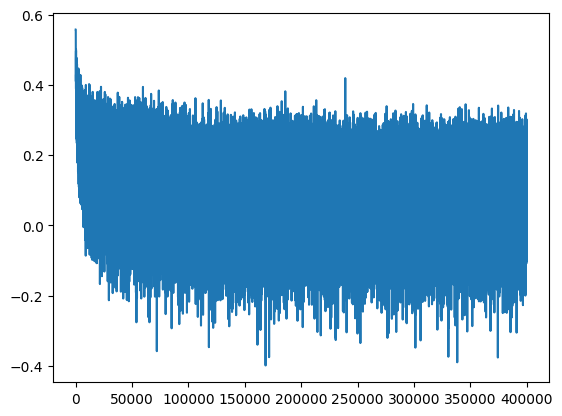

In [9]:
# MLP
vocab_size = number_unique_char
n_embd = 10
n_hidden = 200
mini_batch_size = 32
max_steps = 200000
W1_layers = n_embd * block_size
g = torch.Generator().manual_seed(20260103)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((W1_layers, n_hidden), generator=g) * (5/3)/((W1_layers)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
stepi = []
lossi = []
for i in range(200000):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1 # + b1
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact-bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    if i < 50000:
        lr = 0.01
    elif i < 100000:
        lr = 0.005
    elif i < 150000:
        lr = 0.001
    else:
        lr = 0.0005
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
plt.plot(lossi)

# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

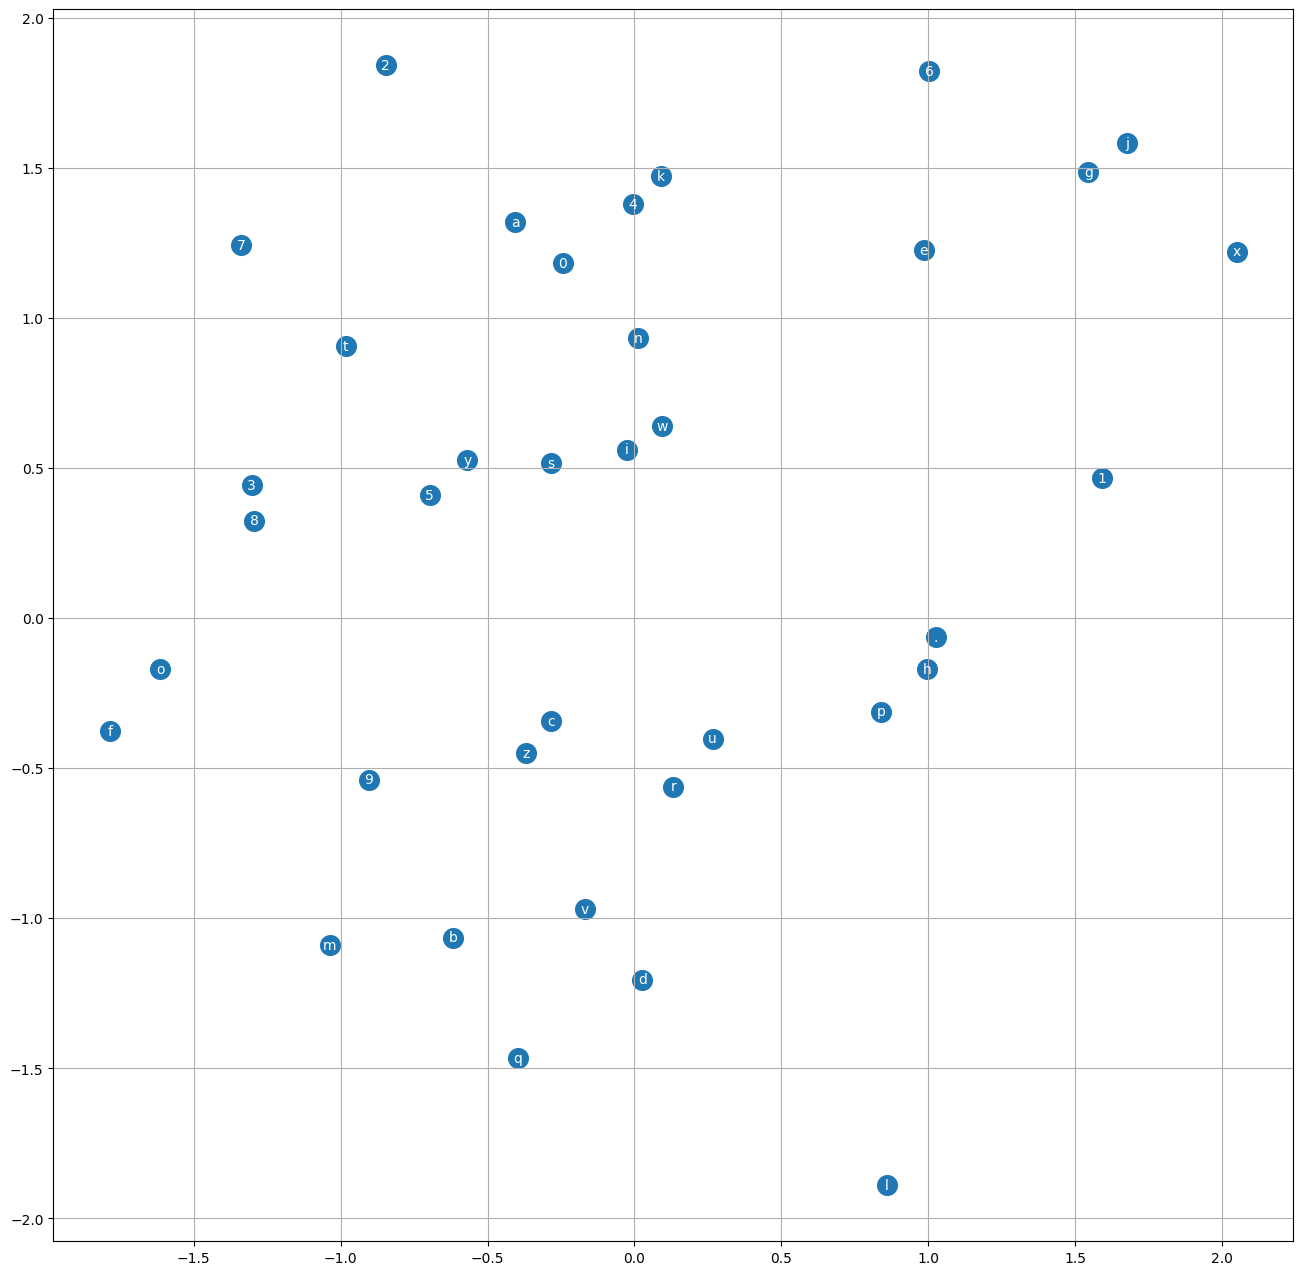

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid(True)

In [13]:
for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

5.
5.
affor.
qagkinglaws.
frommesultal3.
20066.
tralizutn8ratkhenzmhtoy50.
008164we.
5.
5.
qthgovtancquprecludgrierspreveny5es.
5sationach.
qu.
qburewonthang.
5.
q36ctions.
anyty.
1quion.
31.
5.


In [12]:
# predict/ sample
g = torch.Generator().manual_seed(2147483647)
for i in range(5):

    out = []
    ix = 0
    while True:

        # ----------
        # BEFORE:
        # p = P[ix]
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=number_unique_char).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        # ----------

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

vere.
ie.
litrens.
on.
osf.


In [19]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    """
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        # forward the model to get the logits for the index in the sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # either sample from the distribution or take the most likely element
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def print_samples(num=10):
    """ samples from the model and pretty prints the decoded samples """
    X_init = torch.zeros(num, 1, dtype=torch.long).to('cpu')
    top_k = 10
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(model, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        # get the i'th row of sampled integers, as python list
        row = X_samp[i, 1:].tolist() # note: we need to crop out the first <START> token
        # token 0 is the <STOP> token, so we crop the output sequence at that point
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        # separately track samples that we have and have not seen before
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word)
    print('-'*80)

@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        batch = [t.to('cpu') for t in batch]
        X, Y = batch
        logits, loss = model(X, Y)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss


In [60]:
# dataset loader
class CharDataset(Dataset):

    def __init__(self, words, chars, max_word_length):
        self.words = words
        self.chars = chars
        self.max_word_length = max_word_length
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()} # inverse mapping

    def __len__(self):
        return len(self.words)

    def contains(self, word):
        return word in self.words

    def get_vocab_size(self):
        return len(self.chars) + 1 # all the possible characters and special 0 token

    def get_output_length(self):
        return self.max_word_length + 1 # <START> token followed by words

    def encode(self, word):
        ix = torch.tensor([self.stoi[w] for w in word], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        word = self.words[idx]
        ix = self.encode(word)
        x = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1 # index -1 will mask the loss at the inactive locations
        return x, y

def create_datasets(input_file):

    # preprocessing of the input text file
    reader = PdfReader(input_file)
    for i in range(len(reader.pages)):
        page = reader.pages[i]
        global text
        text = text + page.extract_text()
    clean_text = re.sub(r'[^\w]', ' ', text).lower()
    clean_text = re.sub(r'_', ' ', clean_text)
    words = clean_text.split()
    chars = sorted(list(set(clean_text))) # all the possible characters
    number_unique_char =len(chars)
    max_word_length = max(len(w) for w in words)
    print(f"number of examples in the dataset: {len(words)}")
    print(f"max word length: {max_word_length}")
    print(f"number of unique characters in the vocabulary: {number_unique_char}")
    print("vocabulary:")
    print(''.join(chars))

    # partition the input data into a training and the test set
    test_set_size = min(1000, int(len(words) * 0.1)) # 10% of the training set, or up to 1000 examples
    rp = torch.randperm(len(words)).tolist()
    train_words = [words[i] for i in rp[:-test_set_size]]
    test_words = [words[i] for i in rp[-test_set_size:]]
    print(f"split up the dataset into {len(train_words)} training examples and {len(test_words)} test examples")

    # wrap in dataset objects
    train_dataset = CharDataset(train_words, chars, max_word_length)
    test_dataset = CharDataset(test_words, chars, max_word_length)

    return train_dataset, test_dataset

class InfiniteDataLoader:
    """
    this is really hacky and I'm not proud of it, but there doesn't seem to be
    a better way in PyTorch to just create an infinite dataloader?
    """

    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

In [61]:
train_dataset, test_dataset = create_datasets('ISDA.pdf')

number of examples in the dataset: 41532
max word length: 17
number of unique characters in the vocabulary: 37
vocabulary:
 0123456789abcdefghijklmnopqrstuvwxyz
split up the dataset into 40532 training examples and 1000 test examples


In [116]:
from dataclasses import dataclass
@dataclass
class ModelConfig:
    block_size: int = None # length of the input sequences of integers
    vocab_size: int = None # the input integers are in range [0 .. vocab_size -1]
    # parameters below control the sizes of each model slightly differently
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4
    head_size: int =64

In [74]:
# MLP language model

class MLP(nn.Module):
    """
    takes the previous block_size tokens, encodes them with a lookup table,
    concatenates the vectors and predicts the next token with an MLP.

    Reference:
    Bengio et al. 2003 https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
    """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.wte = nn.Embedding(config.vocab_size + 1, config.n_embd) # token embeddings table
        # +1 in the line above for a special <BLANK> token that gets inserted if encoding a token
        # before the beginning of the input sequence
        self.mlp = nn.Sequential(
            nn.Linear(self.block_size * config.n_embd, config.n_embd2),
            nn.Tanh(),
            nn.Linear(config.n_embd2, self.vocab_size)
        )

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):

        # gather the word embeddings of the previous 3 words
        embs = []
        for k in range(self.block_size):
            tok_emb = self.wte(idx) # token embeddings of shape (b, t, n_embd)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = self.vocab_size  # special <BLANK> token at index vocab_size (valid since embedding has vocab_size+1)
            embs.append(tok_emb)

        # concat all of the embeddings together and pass through an MLP
        x = torch.cat(embs, -1) # (b, t, n_embd * block_size)
        logits = self.mlp(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss


In [70]:
# init datasets
train_dataset, test_dataset = create_datasets('ISDA.pdf')
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
print(f"dataset determined that: {vocab_size=}, {block_size=}")
writer = SummaryWriter(log_dir='./training_dir')
# init model
config = ModelConfig(vocab_size=vocab_size, block_size=block_size,
                       n_layer=4, n_head=4,
                       n_embd=64, n_embd2=64)

number of examples in the dataset: 48454
max word length: 17
number of unique characters in the vocabulary: 37
vocabulary:
 0123456789abcdefghijklmnopqrstuvwxyz
split up the dataset into 47454 training examples and 1000 test examples
dataset determined that: vocab_size=38, block_size=18


In [71]:
train_dataset.get_output_length

<bound method CharDataset.get_output_length of <__main__.CharDataset object at 0x324b04d50>>

In [75]:
model = MLP(config)

In [76]:
if __name__ == '__main__':
    # init optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)

    # init dataloader
    batch_loader = InfiniteDataLoader(train_dataset, batch_size=4, pin_memory=True, num_workers=0)

    # training loop
    best_loss = None
    step = 0
    while True:

        t0 = time.time()

        # get the next batch, ship to device, and unpack it to input and target
        batch = batch_loader.next()
        batch = [t.to('cpu') for t in batch]
        X, Y = batch

        # feed into the model
        logits, loss = model(X, Y)

        # calculate the gradient, update the weights
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        t1 = time.time()

        # logging
        if step % 10 == 0:
            print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")
        # evaluate the model
        if step > 0 and step % 500 == 0:
            train_loss = evaluate(model, train_dataset, batch_size=100, max_batches=10)
            test_loss  = evaluate(model, test_dataset,  batch_size=100, max_batches=10)
            writer.add_scalar("Loss/train", train_loss, step)
            writer.add_scalar("Loss/test", test_loss, step)
            writer.flush()
            print(f"step {step} train loss: {train_loss} test loss: {test_loss}")
            # save the model to disk if it has improved
            if best_loss is None or test_loss < best_loss:
                out_path = os.path.join('./training_dir', "model.pt")
                print(f"test loss {test_loss} is the best so far, saving model to {out_path}")
                torch.save(model.state_dict(), out_path)
                best_loss = test_loss

        # sample from the model
        if step > 0 and step % 200 == 0:
            print_samples(num=10)

        step += 1


step 0 | loss 3.6236 | step time 3.03ms
step 10 | loss 3.0017 | step time 13.86ms
step 20 | loss 2.8960 | step time 1.42ms
step 30 | loss 3.1582 | step time 1.04ms
step 40 | loss 2.9049 | step time 1.12ms
step 50 | loss 2.8922 | step time 1.27ms
step 60 | loss 2.9072 | step time 1.39ms
step 70 | loss 3.1316 | step time 1.45ms
step 80 | loss 2.6939 | step time 1.23ms
step 90 | loss 2.7538 | step time 1.36ms
step 100 | loss 2.7910 | step time 1.37ms
step 110 | loss 2.2202 | step time 1.27ms
step 120 | loss 2.5225 | step time 1.72ms
step 130 | loss 2.5029 | step time 1.66ms
step 140 | loss 2.1388 | step time 1.24ms
step 150 | loss 2.4740 | step time 1.33ms
step 160 | loss 2.6776 | step time 2.24ms
step 170 | loss 2.4991 | step time 1.36ms
step 180 | loss 2.3358 | step time 1.17ms
step 190 | loss 2.5588 | step time 1.13ms
step 200 | loss 2.4773 | step time 1.94ms
--------------------------------------------------------------------------------
3 samples that are in train:
t
than
st
0 sample

KeyboardInterrupt: 

In [28]:
text=''

In [77]:
# RNN
class RNNCell(nn.Module):
    """
    the job of a 'Cell' is to:
    take input at current time step x_{t} and the hidden state at the
    previous time step h_{t-1} and return the resulting hidden state
    h_{t} at the current timestep
    """
    def __init__(self, config):
        super().__init__()
        self.xh_to_h = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        xh = torch.cat([xt, hprev], dim=1)
        ht = F.tanh(self.xh_to_h(xh))
        return ht

class GRUCell(nn.Module):
    """
    same job as RNN cell, but a bit more complicated recurrence formula
    that makes the GRU more expressive and easier to optimize.
    """
    def __init__(self, config):
        super().__init__()
        # input, forget, output, gate
        self.xh_to_z = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_r = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_hbar = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        # first use the reset gate to wipe some channels of the hidden state to zero
        xh = torch.cat([xt, hprev], dim=1)
        r = F.sigmoid(self.xh_to_r(xh))
        hprev_reset = r * hprev
        # calculate the candidate new hidden state hbar
        xhr = torch.cat([xt, hprev_reset], dim=1)
        hbar = F.tanh(self.xh_to_hbar(xhr))
        # calculate the switch gate that determines if each channel should be updated at all
        z = F.sigmoid(self.xh_to_z(xh))
        # blend the previous hidden state and the new candidate hidden state
        ht = (1 - z) * hprev + z * hbar
        return ht

class RNN(nn.Module):

    def __init__(self, config, cell_type):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # token embeddings table
        if cell_type == 'rnn':
            self.cell = RNNCell(config)
        elif cell_type == 'gru':
            self.cell = GRUCell(config)
        self.lm_head = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()

        # embed all the integers up front and all at once for efficiency
        emb = self.wte(idx) # (b, t, n_embd)

        # sequentially iterate over the inputs and update the RNN state each tick
        hprev = self.start.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            ht = self.cell(xt, hprev) # (b, n_embd2)
            hprev = ht
            hiddens.append(ht)

        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

In [78]:
rnnmodel = RNN(config, cell_type='rnn')

In [79]:
if __name__ == '__main__':
    # init optimizer
    optimizer = torch.optim.AdamW(rnnmodel.parameters(), lr=5e-4, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)

    # init dataloader
    batch_loader = InfiniteDataLoader(train_dataset, batch_size=4, pin_memory=True, num_workers=0)

    # training loop
    best_loss = None
    step = 0
    while True:

        t0 = time.time()

        # get the next batch, ship to device, and unpack it to input and target
        batch = batch_loader.next()
        batch = [t.to('cpu') for t in batch]
        X, Y = batch

        # feed into the model
        logits, loss = rnnmodel(X, Y)

        # calculate the gradient, update the weights
        rnnmodel.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        t1 = time.time()

        # logging
        if step % 10 == 0:
            print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")
        # evaluate the model
        if step > 0 and step % 500 == 0:
            train_loss = evaluate(rnnmodel, train_dataset, batch_size=100, max_batches=10)
            test_loss  = evaluate(rnnmodel, test_dataset,  batch_size=100, max_batches=10)
            writer.add_scalar("Loss/train", train_loss, step)
            writer.add_scalar("Loss/test", test_loss, step)
            writer.flush()
            print(f"step {step} train loss: {train_loss} test loss: {test_loss}")
            # save the model to disk if it has improved
            if best_loss is None or test_loss < best_loss:
                out_path = os.path.join('./training_dir', "rnnmodel.pt")
                print(f"test loss {test_loss} is the best so far, saving model to {out_path}")
                torch.save(rnnmodel.state_dict(), out_path)
                best_loss = test_loss

        # sample from the model
        if step > 0 and step % 200 == 0:
            print_samples(num=10)

        step += 1


step 0 | loss 3.7172 | step time 7.19ms
step 10 | loss 3.5565 | step time 2.10ms
step 20 | loss 3.4932 | step time 1.77ms
step 30 | loss 3.3850 | step time 1.79ms
step 40 | loss 3.4093 | step time 1.60ms
step 50 | loss 2.9856 | step time 1.83ms
step 60 | loss 3.3461 | step time 1.55ms
step 70 | loss 2.4026 | step time 1.70ms
step 80 | loss 2.9333 | step time 1.76ms
step 90 | loss 2.6608 | step time 1.62ms
step 100 | loss 3.1011 | step time 1.66ms
step 110 | loss 2.7768 | step time 1.80ms
step 120 | loss 2.7608 | step time 1.55ms
step 130 | loss 2.7725 | step time 1.68ms
step 140 | loss 2.7119 | step time 1.49ms
step 150 | loss 2.5302 | step time 1.40ms
step 160 | loss 2.3010 | step time 1.49ms
step 170 | loss 2.5818 | step time 1.43ms
step 180 | loss 2.6745 | step time 1.61ms
step 190 | loss 2.4950 | step time 1.50ms
step 200 | loss 2.2055 | step time 1.55ms
--------------------------------------------------------------------------------
7 samples that are in train:
party
of
party
cond

KeyboardInterrupt: 

In [23]:
# Transformer Language Model (*exactly* as used in GPT-2)

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(m.act(m.c_fc(x))) # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class Transformer(nn.Module):
    """ Transformer Language Model, exactly as seen in GPT-2 """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss


In [46]:
# init model
config = ModelConfig(vocab_size=vocab_size, block_size=42,
                       n_layer=4, n_head=4,
                       n_embd=64, n_embd2=64)
transformer = Transformer(config)

number of parameters: 0.21M


In [49]:
from PyPDF2 import PdfReader
import re
reader = PdfReader('ISDA.pdf')
text=''
for i in range(len(reader.pages)):
    page = reader.pages[i]
    text += page.extract_text()
clean_text = re.sub(r'[^\w]', ' ', text).lower()
clean_text = re.sub(r'_', ' ', clean_text)
raw_text = clean_text.split()
number_unique_char =len(set(clean_text))
chars = sorted(list(set(clean_text))) # all the possible characters
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder:


In [51]:
def get_batch(split, config):
    if split == 'train':
        data = train_data 
    else:
        data = val_data
    ix = torch.randint(len(data) - config.block_size, (config.batch_size,))
    x = torch.stack([data[i:i+config.block_size] for i in ix])
    y = torch.stack([data[i+1:i+config.block_size+1] for i in ix])
    return x, y
xb, yb = get_batch('train', config)

NameError: name 'train_data' is not defined

In [104]:
n_embd

10

In [123]:
# init model
config = ModelConfig(vocab_size=vocab_size, block_size=42,
                       n_layer=4, n_head=4,
                       n_embd=64, head_size=16, n_embd2=64)

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, n_embd, head_size, block_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.head_size = head_size

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B,T,head_size)
        q = self.query(x) # (B,T,head_size)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * (1.0 / math.sqrt(self.head_size)) # (B,T,head_size) @ (B,head_size,T) -> (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B,T,T)
        wei = F.softmax(wei, dim=-1) # (B,T,T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,head_size)
        out = wei @ v # (B,T,T) @ (B,T,head_size) -> (B,T,head_size)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embd, head_size, block_size) for _ in range(num_heads)])

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # (B, T, num_heads * head_size)
        return out

class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embedding = nn.Embedding(config.block_size, config.n_embd)
        self.sa_heads = MultiHeadAttention(config.n_head, config.head_size, config.n_embd, config.block_size)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding(idx) # (B,T,n_embd)
        pos_emb = self.position_embedding(torch.arange(T)) # (T,n_embd)
        x = tok_emb + pos_emb # (B,T,n_embd)
        x = self.sa_heads(x) # (B,T,n_embd)
        logits = self.lm_head(x) # (B,T,vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        return logits, loss
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B,C)
            probs = F.softmax(logits, dim=-1) # (B,C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            idx = torch.cat((idx, idx_next), dim=1) # (B,T+1)
        return idx

In [126]:
transformer = Transformer(config)
if __name__ == '__main__':
    # init optimizer
    optimizer = torch.optim.AdamW(transformer.parameters(), lr=5e-4, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)

    # init dataloader
    batch_loader = InfiniteDataLoader(train_dataset, batch_size=4, pin_memory=True, num_workers=0)

    # training loop
    best_loss = None
    step = 0
    while True:

        t0 = time.time()

        # get the next batch, ship to device, and unpack it to input and target
        batch = batch_loader.next()
        batch = [t.to('cpu') for t in batch]
        X, Y = batch

        # feed into the model
        logits, loss = transformer(X, Y)

        # calculate the gradient, update the weights
        transformer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        t1 = time.time()

        # logging
        if step % 10 == 0:
            print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")
        # evaluate the model
        if step > 0 and step % 500 == 0:
            train_loss = evaluate(transformer, train_dataset, batch_size=100, max_batches=10)
            test_loss  = evaluate(transformer, test_dataset,  batch_size=100, max_batches=10)
            writer.add_scalar("Loss/train", train_loss, step)
            writer.add_scalar("Loss/test", test_loss, step)
            writer.flush()
            print(f"step {step} train loss: {train_loss} test loss: {test_loss}")
            # save the model to disk if it has improved
            if best_loss is None or test_loss < best_loss:
                out_path = os.path.join('./training_dir', "transformer.pt")
                print(f"test loss {test_loss} is the best so far, saving model to {out_path}")
                torch.save(transformer.state_dict(), out_path)
                best_loss = test_loss
            if test_loss<0.8:
                break
        # sample from the model
        if step > 0 and step % 200 == 0:
            print_samples(num=10)

        step += 1


step 0 | loss 3.6820 | step time 2.66ms
step 10 | loss 3.4814 | step time 1.88ms
step 20 | loss 3.1431 | step time 1.45ms
step 30 | loss 2.8475 | step time 1.60ms
step 40 | loss 3.2368 | step time 1.60ms
step 50 | loss 2.9907 | step time 1.49ms
step 60 | loss 2.9302 | step time 1.57ms
step 70 | loss 2.7554 | step time 1.69ms
step 80 | loss 3.1717 | step time 1.77ms
step 90 | loss 2.7970 | step time 1.64ms
step 100 | loss 2.6394 | step time 1.68ms
step 110 | loss 2.7169 | step time 1.62ms
step 120 | loss 2.7012 | step time 1.44ms
step 130 | loss 2.6662 | step time 1.91ms
step 140 | loss 2.2316 | step time 1.76ms
step 150 | loss 2.9680 | step time 1.82ms
step 160 | loss 2.9135 | step time 1.68ms
step 170 | loss 2.0937 | step time 1.74ms
step 180 | loss 1.9751 | step time 1.62ms
step 190 | loss 2.1826 | step time 1.76ms
step 200 | loss 2.4558 | step time 1.55ms
--------------------------------------------------------------------------------
7 samples that are in train:
and
and
the
agent
b

KeyboardInterrupt: 

In [45]:
len(batch)

2